**Step 1: Install Required Libraries**

In [ ]:
!pip install pandas
!pip install geopandas
!pip install rasterio
!pip install rasterstats
!pip install contextily
!pip install scikit-learn
!pip install folium
!pip install seaborn
!pip install matplotlib


In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio
import rasterstats
import contextily
import sklearn as skl
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import mapping, box
from rasterstats import point_query

**Step 2: Load Datasets**

In [ ]:
import geopandas as gpd

gdf = gpd.read_file("/content/polio virus.geojson")

print(gdf.head())
print(gdf.crs)


   ogc_fid zone finalclassification  ward frequency  \
0        1  NWZ                   7              38   
1        2  NWZ                   7              37   
2        3  NWZ                   7              36   
3        4  NWZ                   7              35   
4        5  NEZ                   7              34   

                             concat   state           lga            ward  \
0  SokotoSokoto NorthMagajin Gari B  Sokoto  Sokoto North  Magajin Gari B   
1  SokotoSokoto NorthMagajin Gari B  Sokoto  Sokoto North  Magajin Gari B   
2  SokotoSokoto NorthMagajin Gari B  Sokoto  Sokoto North  Magajin Gari B   
3  SokotoSokoto NorthMagajin Gari B  Sokoto  Sokoto North  Magajin Gari B   
4             BornoMaiduguriGamboru   Borno     Maiduguri         Gamboru   

  settlement wardcode  ... ri opv sia ipv ri ipv  nucleotide    linkage  \
0       None    61606  ...    NaN     NaN    NaN     39-46nt  NIE-ZAS-1   
1       None    61606  ...    NaN     NaN    NaN  39 nt/

In [ ]:
import geopandas as gpd

lga = gpd.read_file("/content/lga.shp")

print(lga.head())
print(lga.crs)


   ogc_fid    rowid  ogc_fid0     amapcode  \
0      1.0  28145.0   28145.0  NIE OSS APM   
1      2.0  28146.0   28146.0  NIE OSS KRE   
2      3.0  28147.0   28147.0  NIE OSS GBN   
3      4.0  28148.0   28148.0  NIE OSS LGB   
4      5.0  28149.0   28149.0  NIE OSS PMD   

                               globalid                  timestamp  \
0  ba9ce4cf-c6bc-4cce-aee5-e2726c172b6a  2020-02-10T12:11:23+01:00   
1  b8a66a2a-f429-4d30-809a-f33b0bfdd1a2  2020-02-10T12:11:23+01:00   
2  2cbf968a-276a-43e5-a6d1-779ef54b8a9a  2020-02-10T12:11:23+01:00   
3  69612f05-7505-41ff-910e-51cd6c21f4c7  2020-02-10T12:11:23+01:00   
4  e6a65dfe-9ee7-4514-8270-3ce30f12de0f  2020-02-10T12:11:23+01:00   

         source statecode    lganame lgacode      editor statename  ratio  \
0  IPD_Campaign        OS     Isokan   30022  najib.adam      Osun  1.006   
1  IPD_Campaign        OS    Irewole   30021  najib.adam      Osun  0.971   
2  IPD_Campaign        OS    Ayedade   30001  najib.adam      Osun  0.7

In [ ]:
import rasterio

# open raster
pop_raster = rasterio.open("/content/Pop-Density.tif")

# print raster info
print("CRS:", pop_raster.crs)
print("Width:", pop_raster.width)
print("Height:", pop_raster.height)
print("Bounds:", pop_raster.bounds)
print("Pixel size:", pop_raster.res)


CRS: EPSG:32632
Width: 14569
Height: 11656
Bounds: BoundingBox(left=-203994.5089, bottom=472019.8543, right=1131282.6306, top=1544908.9384)
Pixel size: (91.65194175990116, 92.04607790837338)


In [ ]:
import geopandas as gpd

waterbody = gpd.read_file("/content/waterbody.shp")

# Preview first rows
print(waterbody.head())

# Check CRS
print(waterbody.crs)


   ogc_fid  objectid statecode              name   type  \
0      1.0       1.0        PL      Chinkwan Dam  Water   
1      2.0       2.0        PL  Gura Topp Pond 1  Water   
2      3.0       3.0        PL      Pankshin Dam  Water   
3      4.0       4.0      None       Kupto River   None   
4      5.0       5.0        PL       Daurawa Dam  Water   

                 timestamp       source                              globalid  \
0  2013/11/26 05:30:46.000  eHA-TeamGIS  d7024308-0ccc-4c39-954e-09962713a70b   
1  2013/11/14 06:20:54.000  eHA-TeamGIS  80344418-0a8b-4060-91a5-d6797f7cc2c7   
2  2013/11/28 23:58:13.000  eHA-TeamGIS  d96d524c-2137-4a27-a8c1-bea2b8825b78   
3  2013/11/13 05:10:05.000  eHA-TeamGIS  c0976bf3-ec2e-4f32-8b03-74237f7c0fc2   
4  2013/11/14 05:57:25.000  eHA-TeamGIS  468a843b-b921-4e90-9a19-684c422bbc18   

                                            geometry  
0  POLYGON ((9.53589 8.89221, 9.52782 8.89305, 9....  
1  POLYGON ((8.90882 9.82723, 8.90906 9.82728, 8

**Step 3: Process and ensure consistence CRS**

In [59]:
import geopandas as gpd

# Load LGA polygons
lga = gpd.read_file("/content/lga.shp")  # make sure CRS is projected
lga = lga.to_crs(epsg=32632)  # metric CRS for distance calculations if needed

# Load polio cases (points)
polio_cases = gpd.read_file("/content/polio virus.geojson")
polio_cases = polio_cases.to_crs(epsg=32632)  # match CRS with LGA


In [60]:
# Perform spatial join: each case gets LGA info
cases_in_lga = gpd.sjoin(polio_cases, lga, how='left', predicate='within')

# Count cases per LGA
polio_counts = cases_in_lga.groupby('lganame').size().reset_index(name='polio_cases')

print(polio_counts.head())


            lganame  polio_cases
0         Aba North            3
1         Ado-Ekiti            1
2  Ajeromi/Ifelodun            1
3            Ajingi            9
4       Akure South            1


In [61]:
lga = lga.merge(polio_counts, on='lganame', how='left')

# Fill LGAs with no cases with 0
lga['polio_cases'] = lga['polio_cases'].fillna(0).astype(int)

print(lga[['lganame', 'polio_cases']].head())


     lganame  polio_cases
0     Isokan            0
1    Irewole            3
2    Ayedade            0
3    Ayedire            0
4  Ife North            0


**Step 4: Features extration for each Administrative uni**

Compute zonal statistics for population density for each Admin unit



In [62]:
import geopandas as gpd
from rasterstats import zonal_stats

# Load LGA shapefile
lga = gpd.read_file("/content/lga.shp")

# Reproject to match raster CRS
lga_utm = lga.to_crs("EPSG:32632")

# Run zonal statistics
pop_raster = "/content/Pop-Density.tif"

stats = zonal_stats(
    lga_utm,
    pop_raster,
    stats=['mean'],
    nodata=-3.3999999521443642e+38,
    all_touched=True
)

# Add results
lga_utm["avg_pop_density"] = [s['mean'] for s in stats]

# Save output
lga_utm.to_file("/content/LGA_with_pop_density.shp")

# Preview
print(lga_utm[['lganame', 'avg_pop_density']].head(20))


         lganame  avg_pop_density
0         Isokan         4.757575
1        Irewole         5.116539
2        Ayedade         4.435859
3        Ayedire         3.500345
4      Ife North         4.614059
5         Iseyin         3.068226
6      Itesiwaju         2.268297
7         Kajola         2.980900
8          Donga         4.001239
9           Oyun         4.374127
10         Ogbia         3.578607
11  Afikpo North         5.612779
12       Baruten         2.550450
13        Lagelu         4.431345
14        Kaiama         2.973201
15         Gummi         5.840161
16      Surulere         3.101551
17        Ringim         4.200822
18   Ilorin East         6.971248
19         Takum         3.878605


/tmp/ipython-input-843294604.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  lga_utm.to_file("/content/LGA_with_pop_density.shp")
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'avg_pop_density' to 'avg_pop_de'
  ogr_write(


Distance to the nearest waterbody

Define function to calculate the distance from a point (e.g admin center) to the nearest waterbody

In [64]:
import geopandas as gpd
from shapely.strtree import STRtree

def distance_to_nearest_waterbody(points_gdf, waterbodies_gdf, point_geom_col='geometry', water_geom_col='geometry', projected_crs=32632):
    """
    Calculate the distance from each point to the nearest waterbody.

    Args:
        points_gdf (GeoDataFrame): Points (admin centers, centroids, etc.)
        waterbodies_gdf (GeoDataFrame): Waterbodies polygons or lines
        point_geom_col (str): Column in points_gdf containing geometry
        water_geom_col (str): Column in waterbodies_gdf containing geometry
        projected_crs (int): EPSG code for projected CRS (meters)

    Returns:
        GeoDataFrame: points_gdf with a new column 'dist_to_waterbody'
    """

    # Copy and reproject both layers
    points = points_gdf.copy().to_crs(epsg=projected_crs)
    waterbodies = waterbodies_gdf.copy().to_crs(epsg=projected_crs)

    # Ensure correct geometry column
    points = points.set_geometry(point_geom_col)
    water_geoms = list(waterbodies[water_geom_col])

    # Build STRtree
    strtree = STRtree(water_geoms)

    # Function to compute distance
    def nearest_distance(point):
        nearest_geom = strtree.nearest(point)
        # If nearest_geom is an integer index, convert to geometry
        if not hasattr(nearest_geom, 'geom_type'):
            nearest_geom = water_geoms[nearest_geom]
        return point.distance(nearest_geom)

    # Apply distance calculation
    points['dist_to_waterbody'] = points.geometry.apply(nearest_distance)

    return points


In [65]:
# Load LGA polygons and waterbodies
lga = gpd.read_file("/content/lga.shp")
waterbodies = gpd.read_file("/content/waterbody.shp")

# Compute centroids of LGAs
lga['centroid'] = lga.geometry.centroid
lga_points = lga.copy()
lga_points.set_geometry('centroid', inplace=True)

# Calculate distances
lga_points = distance_to_nearest_waterbody(lga_points, waterbodies, point_geom_col='centroid')

# Preview results
print(lga_points[['lganame', 'dist_to_waterbody']].head())

# Save updated shapefile (keep original polygons if needed)
lga['dist_to_waterbody'] = lga_points['dist_to_waterbody']
# Drop the 'centroid' geometry column before saving to shapefile
lga = lga.drop(columns=['centroid'])
lga.to_file("/content/LGA_with_distances.shp")

     lganame  dist_to_waterbody
0     Isokan      208141.073828
1    Irewole      193647.123096
2    Ayedade      203615.411572
3    Ayedire      177375.395545
4  Ife North      190244.849096


/tmp/ipython-input-1610552277.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lga['centroid'] = lga.geometry.centroid
/tmp/ipython-input-1610552277.py:20: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  lga.to_file("/content/LGA_with_distances.shp")
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'dist_to_waterbody' to 'dist_to_wa'
  ogr_write(


**Prepare Dataset For Pedictive Modeling**

Create a dataframe that includes the extracted features

In [67]:
# Rename truncated distance column if needed
lga = lga.rename(columns={'dist_to_wa': 'dist_to_waterbody'})

# If avg_pop_density column does not exist, create placeholder
if 'avg_pop_density' not in lga.columns:
    lga['avg_pop_density'] = 0  # replace with actual values if available


In [71]:
import pandas as pd
import geopandas as gpd

# Load the base LGA shapefile (for original attributes and geometry)
lga_base = gpd.read_file("/content/lga.shp")
# Ensure it's in the projected CRS for consistency with other processed data
lga_base = lga_base.to_crs(epsg=32632)

# Load the GeoDataFrame with average population density
# Note: the column name was truncated to 'avg_pop_de' when saved
lga_pop_density = gpd.read_file("/content/LGA_with_pop_density.shp")
lga_pop_density = lga_pop_density.rename(columns={'avg_pop_de': 'avg_pop_density'})

# Load the GeoDataFrame with distance to waterbody
# Note: the column name was truncated to 'dist_to_wa' when saved
lga_distances = gpd.read_file("/content/LGA_with_distances.shp")
lga_distances = lga_distances.rename(columns={'dist_to_wa': 'dist_to_waterbody'})

# The 'polio_counts' variable should be available from a previous cell's execution.
# It contains 'lganame' and 'polio_cases'

# Start building the comprehensive 'lga' GeoDataFrame by merging data
# Use lga_base as the starting point to retain original geometry and attributes
lga = lga_base.merge(polio_counts[['lganame', 'polio_cases']], on='lganame', how='left')

# Fill LGAs with no cases with 0 (if any were not covered by polio_counts)
lga['polio_cases'] = lga['polio_cases'].fillna(0).astype(int)

# Merge the population density data
# We only need 'lganame' and the 'avg_pop_density' column from lga_pop_density
lga = lga.merge(lga_pop_density[['lganame', 'avg_pop_density']], on='lganame', how='left')

# Merge the distance to waterbody data
# We only need 'lganame' and the 'dist_to_waterbody' column from lga_distances
lga = lga.merge(lga_distances[['lganame', 'dist_to_waterbody']], on='lganame', how='left')



In [74]:
# Define the features for the predictive model
features = ['statecode', 'lganame', 'lgacode', 'avg_pop_density',
            'dist_to_waterbody', 'polio_cases', 'ratio']

# Create the predictive DataFrame
predictive_df = lga[features].copy()

# Drop geometry column (it should be present in lga from lga_base)
predictive_df = predictive_df.drop(columns='geometry', errors='ignore')

# Preview
print(predictive_df.head())

  statecode    lganame lgacode  avg_pop_density  dist_to_waterbody  \
0        OS     Isokan   30022         4.757575      208141.073828   
1        OS    Irewole   30021         5.116539      193647.123096   
2        OS    Ayedade   30001         4.435859      203615.411572   
3        OS    Ayedire   30002         3.500345      177375.395545   
4        OS  Ife North   30013         4.614059      190244.849096   

   polio_cases  ratio  
0            0  1.006  
1            3  0.971  
2            0  0.742  
3            0  1.113  
4            0  0.447  


**Train Predictive Model**

Use a simple Machine Learning Model (e.g Randomforestclassiffier) to predict the risk of cVPV2 outbreaks

In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define predictors (X) and target (y)
# Example: define high-risk if polio_cases > 0
predictive_df['high_risk'] = (predictive_df['polio_cases'] > 0).astype(int)

# Drop columns that should not be used as predictors
X = predictive_df.drop(columns=['polio_cases', 'high_risk', 'lganame', 'lgacode'])
y = predictive_df['high_risk']

# Encode categorical variables (statecode)
X = pd.get_dummies(X, columns=['statecode'], drop_first=True)

# Scale numeric features (optional but recommended)
numeric_cols = ['avg_pop_density', 'dist_to_waterbody', 'ratio']
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


In [76]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [77]:
# Initialize and train Random Forest
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [78]:
#Predict and evaluate
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[85 17]
 [21 38]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82       102
           1       0.69      0.64      0.67        59

    accuracy                           0.76       161
   macro avg       0.75      0.74      0.74       161
weighted avg       0.76      0.76      0.76       161



In [79]:
# Add predictions to LGA GeoDataFrame
# Predict risk for all LGAs
lga_features = X.copy()
lga['predicted_risk'] = rf_model.predict(lga_features)

# Map risk: 0 = low, 1 = high
print(lga[['lganame', 'predicted_risk']].head())

# Optionally save updated shapefile
lga.to_file("/content/LGA_with_predicted_risk.shp")


     lganame  predicted_risk
0     Isokan               0
1    Irewole               1
2    Ayedade               0
3    Ayedire               0
4  Ife North               0


/tmp/ipython-input-2538215260.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  lga.to_file("/content/LGA_with_predicted_risk.shp")
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'polio_cases' to 'polio_case'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'avg_pop_density' to 'avg_pop_de'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'dist_to_waterbody' to 'dist_to_wa'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'predicted_risk' to 'predicted_'
  ogr_write(


**Visualize the Predicted Risk Map**

Plot the Administrative Boundaries Coloured by Predicted Risk Level

plot predicted risk Map using geopandas

In [86]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load LGA shapefile with predicted risk if not already in memory
lga = gpd.read_file("/content/LGA_with_predicted_risk.shp")



In [87]:
# Rename prediction column
lga = lga.rename(columns={'predicted_': 'predicted_risk'})

# Verify
print(lga[['lganame', 'predicted_risk']].head())



     lganame  predicted_risk
0     Isokan               0
1    Irewole               1
2    Ayedade               0
3    Ayedire               0
4  Ife North               0


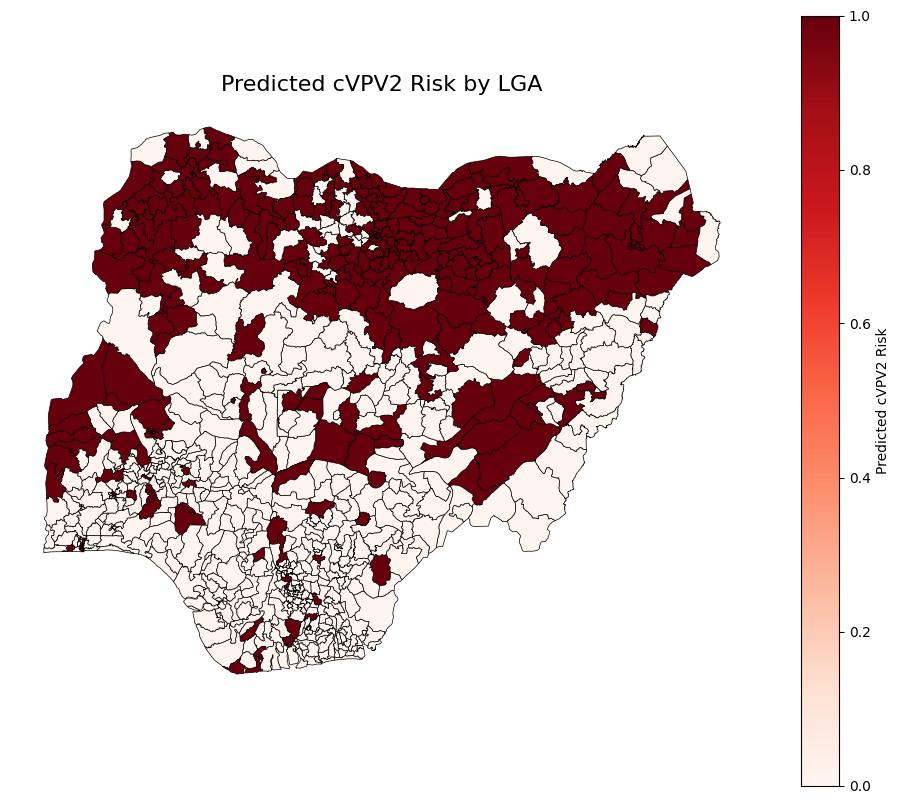

In [88]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
lga.plot(column='predicted_risk', cmap='Reds', legend=True,
         legend_kwds={'label': "Predicted cVPV2 Risk"},
         edgecolor='black', linewidth=0.5, ax=ax)
ax.set_title("Predicted cVPV2 Risk by LGA", fontsize=16)
ax.set_axis_off()
plt.show()


## Insight

The study aimed to predict the risk of cVPV2 outbreaks across LGAs using spatial and epidemiological data.

Administrative boundaries were combined with population density, distance to the nearest waterbody, vaccination coverage, and past polio case counts to create a predictive dataset. Key features extracted included avg_pop_density, dist_to_waterbody, ratio (vaccination coverage), and polio_cases.

A Random Forest classifier was trained to classify LGAs into high-risk and low-risk categories. The model achieved 76% accuracy, with stronger performance in identifying low-risk LGAs (precision 0.80, recall 0.83) and moderate performance for high-risk LGAs (precision 0.69, recall 0.64). Misclassifications were observed primarily among high-risk LGAs, emphasizing the need for cautious interpretation.

The predicted risk map clearly visualized high-risk and low-risk LGAs, highlighting spatial clustering of high-risk areas.

## Recommendations
(1) prioritizing vaccination and surveillance in high-risk LGAs.

(2) integrating the risk map into GIS-based early warning systems for real-time monitoring.

(3) enhancing predictions by incorporating additional outbreak and environmental data.

(4) continuously updating the model with new data to improve preparedness. This approach enables data-driven, targeted public health interventions to prevent cVPV2 spread efficiently.